In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from recurrent_attention import RecurrentAttention

## Overhead stuff

Helper functions for batching, resetting hidden states, etc.

In [2]:
# Training hyperparameters
eval_batch_size = 10
batch_size = 74
seq_len = 18
dropout = 0.1
clip = 0.1
lr = 0.001
lr_factor = 1
warmup_steps = 15
decay_factor = 0.5  # Higher => faster learning rate decay
smooth_labels = False

epochs = 100
log_interval = 100  # Print log every `log_interval` batches

In [3]:
# Model hyperparameters
embed_size = 256
encode_size = 128
h_size = 64
attn_out_size = 128
decode_size = 256
n_layers = 2
attn_rnn_layers = 1
bidirectional_attn = False

In [4]:
# Starting from sequential data, `batchify` arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.
def batchify(data, batch_size):
    # Work out how cleanly we can divide the dataset into batches
    nbatches = data.size(0) // batch_size
    # Trim off any extra elements that wouldn't cleanly fit
    data = data.narrow(0, 0, nbatches * batch_size)
    # Evenly divide the data across the batches
    data = data.view(batch_size, -1).t().contiguous()
    return data

# Wraps hidden states into new Variables to detach them from their history
def repackage_hidden(h):
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)
    
# `get_batch` subdivides the source data into chunks of the specified length.
# E.g., using the example for the `batchify` function above and a length of 2,
# we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the `batchify` function. The chunks are along dimension 0, corresponding
# to the `seq_len` dimension in the LSTM.
def get_batch(source, i, seq_len, evaluate = False):
    seq_len = min(seq_len, len(source) - 1 - i)
    data = Variable(source[i : i+seq_len], volatile = evaluate)
    target = Variable(source[i+1 : i+1+seq_len].view(-1), volatile = evaluate)
    return data, target

Label smoothing class for regularization.

In [5]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx = None, smoothing = 0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        if self.padding_idx is not None:
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad = False))

Learning rate scheduler that sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

In [6]:
def get_lr_scheduler(h_size, factor, warmup, optimizer):
    lrate = lambda e: factor * (h_size**(-0.5) * min((e+1)**(-decay_factor), (e+1) * warmup**(-(decay_factor+1))))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lrate)

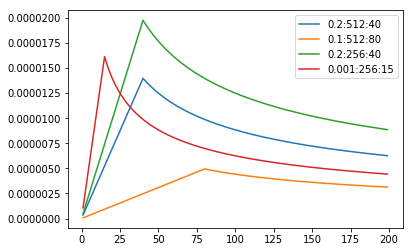

In [7]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(0.002, 512, 40), 
    lrate(0.001, 512, 80),
    lrate(0.002, 256, 40),
    lrate(lr_factor*lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, 200), [[opt(i) for opt in opts] for i in range(1, 200)])
plt.legend(["0.002:512:40", "0.001:512:80", "0.002:256:40", "%.3f:%d:%d" % (lr_factor*lr, embed_size, warmup_steps)])

## Initialize data

In [8]:
corpus = data.Corpus('./data/ptb')
ntokens = len(corpus.dictionary)

## Model class

In [9]:
class RNNModel(nn.Module):
    def __init__(self, src_vocab, tgt_vocab,
                 embed_size, encode_size, h_size,
                 attn_out_size, decode_size, n_layers,
                 attn_rnn_layers, bidirectional_attn,
                 tie_wts = True, dropout = 0.1):
        super(RNNModel, self).__init__()
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.embed_size = embed_size
        self.encode_size = encode_size
        self.h_size = h_size
        self.attn_out_size = attn_out_size
        self.decode_size = decode_size
        self.n_layers = n_layers
        self.attn_rnn_layers = attn_rnn_layers
        self.bidirectional_attn = bidirectional_attn
        self.tie_wts = tie_wts
        self.dropout = dropout
        
        self.drop = nn.Dropout(dropout)
        
        self.embedding = nn.Embedding(src_vocab, embed_size)
        self.encoder = nn.LSTM(
            input_size = embed_size, hidden_size = encode_size,
            num_layers = n_layers, dropout = dropout
        )
        self.attn = RecurrentAttention(
            in_size = encode_size, h_size = h_size, out_size = attn_out_size,
            dropout = dropout, num_rnn_layers = attn_rnn_layers,
            bidirectional = bidirectional_attn
        )
        self.decoder = nn.LSTM(
            input_size = attn_out_size, hidden_size = decode_size,
            num_layers = n_layers, dropout = dropout
        )
        self.projection = nn.Linear(decode_size, tgt_vocab)
        # Tie the embedding and projection matrix weights
        if tie_wts and src_vocab == tgt_vocab and embed_size == decode_size:
            self.embedding.weight = self.projection.weight
        
    def init(self):
        for subnet in [self.encoder, self.decoder]:
            for p in subnet.parameters():
                if p.dim() > 1:
                    nn.init.xavier_normal(p)
                else:
                    p.data.fill_(0)
        for p in self.linear.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)
            else:
                p.data.fill_(0)
        self.attn.init()
        
    def init_states(self, batch_size):
        encoder_states = (
            Variable(torch.zeros(self.n_layers, batch_size, self.encode_size)),
            Variable(torch.zeros(self.n_layers, batch_size, self.encode_size))
        )
        attn_states = self.attn.init_rnn_states(batch_size)
        decoder_states = (
            Variable(torch.zeros(self.n_layers, batch_size, self.decode_size)),
            Variable(torch.zeros(self.n_layers, batch_size, self.decode_size))
        )
        return encoder_states, attn_states, decoder_states
    
    def forward(self, inputs, states):
        enc_states, attn_states, dec_states = states
        relu = nn.ReLU()
        log_softmax = nn.LogSoftmax(dim = -1)
        
        embeddings = self.embedding(inputs) * np.sqrt(self.embed_size)
        enc_out, new_enc_states = self.encoder(self.drop(embeddings))
        attn_out, new_attn_states = self.attn(enc_out, attn_states)
        dec_out, new_dec_states = self.decoder(relu(attn_out))
        output = self.projection(dec_out)
        if smooth_labels:
            output = log_softmax(output)
        return output, (new_enc_states, new_attn_states, new_dec_states)

## Initialize model, criterion, optimizer, and learning rate scheduler

In [10]:
model = RNNModel(
    ntokens, ntokens, embed_size, encode_size, h_size,
    attn_out_size, decode_size, n_layers, attn_rnn_layers,
    bidirectional_attn, dropout = dropout
)
if smooth_labels:
    criterion = LabelSmoothing(ntokens, smoothing = 0.1)
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, lr_factor, warmup_steps, optimizer)

In [11]:
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 3862609


## Train
Ready the data

In [12]:
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

Define training and validation loops

In [13]:
def train():
    # Use random length sequences
    seq_lens = []
    tot_len = 0
    jitter = 0.15 * seq_len
    while tot_len < train_data.size(0) - 2:
        if train_data.size(0) - tot_len - 2 <= seq_len + jitter:
            slen = train_data.size(0) - tot_len - 2
        else:
            slen = int(np.random.normal(seq_len, jitter))
            if slen <= 0:
                slen = seq_len    # eh
            if tot_len + slen >= train_data.size(0) - jitter - 2:
                slen = train_data.size(0) - tot_len - 2
        seq_lens.append(slen)
        tot_len += slen
    # Turn on training mode
    model.train()
    # Initialize RNN states
    states = model.init_states(batch_size)
    # Prep metainfo
    total_loss = 0
    start_time = time.time()
    for batch, i in enumerate(np.cumsum(seq_lens)):
        # Get training data
        data, targets = get_batch(train_data, i, seq_lens[batch])
        # Repackage the hidden states
        states = repackage_hidden(states)
        # Zero out gradients
        model.zero_grad()
        
        # Run the model forward
        output, states = model(data, states)
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        if np.isnan(loss.data[0]):
            return -1
        # Propagate loss gradient backwards
        loss.backward()
        # Clip gradients
        nn.utils.clip_grad_norm(model.parameters(), clip)
        # Scale the batch learning rate so that shorter sequences aren't "stronger"
        scaled_lr = [
            r * np.sqrt(seq_lens[batch] / seq_len) for r in lr_scheduler.get_lr()
        ]
        for param_group, r in zip(optimizer.param_groups, scaled_lr):
            param_group['lr'] = r
        # Adjust parameters
        optimizer.step()
        
        # Get some metainfo
        total_loss += loss.data
        lr = np.mean(scaled_lr)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss[0] / log_interval
            elapsed = time.time() - start_time
            print('{:3d}/{:3d} batches | {:5.2f} ms/batch | lr: {:8.3g} | loss: {:5.2f} | perplexity: {:8.2f}'.format(
                batch, len(seq_lens), elapsed * 1000/log_interval, lr, cur_loss, np.exp(cur_loss)
            ))
            total_loss = 0
            start_time = time.time()
    return 0

In [ ]:
def evaluate(data_src):
    model.eval()
    total_loss = 0
    states = model.init_states(eval_batch_size)
    for i in range(0, data_src.size(0) - 1, seq_len):
        # Get data
        data, targets = get_batch(data_src, i, seq_len, evaluate = True)
        # Repackage the hidden states
        states = repackage_hidden(states)
        # Evaluate
        output, states = model(data, states)
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        total_loss += len(data) * loss.data
    return total_loss[0] / len(data_src)

Train and evaluate

In [ ]:
for epoch in range(epochs):
    lr_scheduler.step()
    print('Epoch {:3d}) lr = {:0.4g}'.format(epoch+1, np.mean(lr_scheduler.get_lr())))
    start_time = time.time()
    stat = train()
    if stat == -1:
        print('\n' + (' '*38) + 'NaN value')
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(val_data)
    print('-' * 85)
    print('Elapsed time: {:5.2f} s | valid_loss: {:5.2f} | valid_perplexity: {:8.2f}'.format(
        elapsed, val_loss, np.exp(val_loss)
    ))
    print('=' * 85)
    print('\n')

Epoch   1) lr = 1.076e-06
100/719 batches | 1102.77 ms/batch | lr: 8.02e-07 | loss:  9.30 | perplexity: 10960.13
200/719 batches | 1031.12 ms/batch | lr: 1.11e-06 | loss:  9.21 | perplexity:  9975.54
300/719 batches | 1069.13 ms/batch | lr: 1.01e-06 | loss:  9.21 | perplexity:  9964.23
400/719 batches | 1060.92 ms/batch | lr: 1.08e-06 | loss:  9.21 | perplexity:  9953.24
500/719 batches | 1104.39 ms/batch | lr: 1.11e-06 | loss:  9.20 | perplexity:  9935.94
600/719 batches | 1040.47 ms/batch | lr: 8.02e-07 | loss:  9.20 | perplexity:  9920.17
700/719 batches | 1067.36 ms/batch | lr: 1.19e-06 | loss:  9.20 | perplexity:  9907.45
-------------------------------------------------------------------------------------
Elapsed time: 765.88 s | valid_loss:  9.20 | valid_perplexity:  9885.46


Epoch   2) lr = 2.152e-06
100/717 batches | 1062.82 ms/batch | lr: 2.09e-06 | loss:  9.29 | perplexity: 10832.73
200/717 batches | 1094.24 ms/batch | lr: 2.03e-06 | loss:  9.19 | perplexity:  9840.40
300/7

In [ ]:
test_loss = evaluate(test_data)
print('test_loss: {:5.2f} | test_perplexity: {:8.2f}'.format(
    test_loss, np.exp(test_loss)
))

## Generate some random words
Just, like, y'know, as a test or whatever.

In [ ]:
num_words = 1000

states = model.init_states(1)
cur_word = Variable(torch.rand(1, 1).mul(ntokens).long(), volatile = True)
gen_text = [int(cur_word)]

for i in range(num_words):
    output, hidden = model(cur_word, states)
    word_weights = output.squeeze().exp()
    word_idx = torch.multinomial(word_weights, 1).data[0]
    gen_text.append(int(word_idx))
    cur_word.data.fill_(word_idx)

In [ ]:
# Print the words
print(' '.join([corpus.dictionary.idx2word[i] for i in gen_text]))